In [1]:
import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap

import pandas as pd
import geopandas as gpd

In [2]:
releases = gpd.read_file("./input/toxic_release_pennsylvania/toxic_release_pennsylvania/toxic_release_pennsylvania.shp") 
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


In [3]:
stations = gpd.read_file("./input/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations/PhillyHealth_Air_Monitoring_Stations.shp")
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


In [4]:
print(stations.crs)
print(releases.crs)

epsg:2272
epsg:2272


In [5]:
# Select one release incident in particular
recent_release = releases.iloc[360]

# Measure distance from release to each station
distances = stations.geometry.distance(recent_release.geometry)
distances

0     44778.509761
1     51006.456589
2     77744.509207
3     14672.170878
4     43753.554393
5      4711.658655
6     23197.430858
7     12072.823097
8     79081.825506
9      3780.623591
10    27577.474903
11    19818.381002
dtype: float64

In [6]:
print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))

Mean distance to monitoring stations: 33516.28487007786 feet


In [7]:
print('Closest monitoring station ({} feet):'.format(distances.min()))
print(stations.iloc[distances.idxmin()][["ADDRESS", "LATITUDE", "LONGITUDE"]])

Closest monitoring station (3780.623590556444 feet):
ADDRESS      3100 Penrose Ferry Road
LATITUDE                     39.9128
LONGITUDE                   -75.1854
Name: 9, dtype: object


In [8]:
stations.shape

(12, 24)

In [9]:
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


In [10]:
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer.head()

0    POLYGON ((2721944.641 257149.310, 2721893.792 ...
1    POLYGON ((2682494.290 271248.900, 2682443.441 ...
2    POLYGON ((2744886.638 280980.247, 2744835.789 ...
3    POLYGON ((2703638.580 233247.101, 2703587.731 ...
4    POLYGON ((2726959.773 251134.976, 2726908.924 ...
dtype: geometry

In [11]:
# Create map with release incidents and monitoring stations
m = folium.Map(location=[39.9526,-75.1652], zoom_start=11)
HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)
for idx, row in stations.iterrows():
    Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)
    
# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)

# Show the map
m

Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


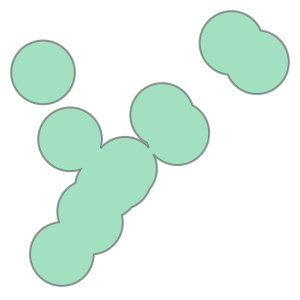

In [12]:
# Turn group of polygons into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the MultiPolygon object
my_union

In [13]:
# The closest station is less than two miles away
my_union.contains(releases.iloc[360].geometry)

True

In [14]:
# The closest station is more than two miles away
my_union.contains(releases.iloc[358].geometry)

False